In [2]:
import json
import numpy as np
import matplotlib.pylab as plt
from mne import read_epochs, pick_types
from scipy.interpolate import interp1d, PchipInterpolator, Akima1DInterpolator
from scipy.stats import norm
import os.path as op
from tools import *

In [3]:
def plot_csd(smooth_csd, list_ROI_vertices, bb_path, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None):
    layer_labels = ["I", "II", "III", "IV", "V", "VI"]
    with open(bb_path, "r") as fp:
        bb = json.load(fp)
    bb = [np.array(bb[i])[list_ROI_vertices] for i in bb.keys()]
    bb_mean = [np.mean(i) for i in bb]
    bb_std = [np.std(i) for i in bb]
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    for l_ix, th in enumerate(np.cumsum(bb_mean)):
            ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
            # ax.axhspan(th-bb_std[l_ix], th+bb_std[l_ix], alpha=0.05, color="black", lw=0)
            ax.annotate(layer_labels[l_ix],[times[0]+0.01, th-0.01],size=15)
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()

In [4]:
js_inf = "/home/common/bonaiuto/multiburst/derivatives/processed/sub-001/multilayer_11/info.json"
with open(js_inf) as pipeline_file:
    info = json.load(pipeline_file)

In [5]:
info

{'dataset_dir': '/home/common/bonaiuto/multiburst/derivatives/processed',
 'which_dataset': 'multilayer_11',
 'anatomy_dir': '/home/common/bonaiuto/cued_action_meg/derivatives/processed',
 'old_dataset': '/home/common/bonaiuto/cued_action_meg',
 'annot_paths': ['/home/mszul/git/DANC_multilayer_laminar/assets/lh.HCPMMP1.annot',
  '/home/mszul/git/DANC_multilayer_laminar/assets/rh.HCPMMP1.annot'],
 'fsavg_sphere_paths': ['/home/mszul/git/DANC_multilayer_laminar/assets/lh.sphere.reg.gii',
  '/home/mszul/git/DANC_multilayer_laminar/assets/rh.sphere.reg.gii'],
 'atlas': '/home/mszul/git/DANC_multilayer_laminar/assets/atlas_glasser_2016.csv',
 'subject_info': '/home/common/bonaiuto/multiburst/participants.tsv',
 'freesurfer_singularity': '/scratch/freesurfer_lic.sif',
 'big_brain_path': '/home/mszul/git/DANC_multilayer_laminar/assets/big_brain_layer_thickness',
 'layers': 11,
 'T1_dir': '/home/common/bonaiuto/cued_action_meg/raw/{}/mri/headcast/t1w.nii',
 'fsnat_sphere_paths': ['/home/common

In [6]:
file_ix = 0

# specific info
crop_info = {
    "visual": (-0.2, 0.8),
    "motor": (-0.5, 0.5)
}
# computation
fif_MU = list(zip(info["sensor_epochs_paths"], info["MU_paths"]))
fif, MU = fif_MU[file_ix]
epo_type = [i for i in crop_info.keys() if i in fif][0]

fif = read_epochs(fif, verbose=False)
fif = fif.pick_types(meg=True, ref_meg=False, misc=False)
fif = fif.crop(tmin=crop_info[epo_type][0], tmax=crop_info[epo_type][1])
sfreq = fif.info["sfreq"]
fif_times = fif.times
fif = fif.get_data()
fif = np.mean(fif, axis=0)

new_mu_path = MU.split(".")[0] + ".npy"
if not op.exists(new_mu_path):
    MU = pd.read_csv(MU, sep="\t", header=None).to_numpy()
    np.save(new_mu_path, MU)
elif op.exists(new_mu_path):
    MU = np.load(new_mu_path)

MU = np.split(MU, info["n_surf"], axis=0)
flims = [0.1,125]

layer_shape = MU[0].shape[0]
cortical_thickness = np.load(info["cortical_thickness_path"])

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Removing 5 compensators from info because not all compensation channels were picked.


In [15]:
src = []
for i in range(layer_shape):
    vertex_layers = np.array([mx[i] for mx in MU])
    vertex_source = np.dot(fif.T, vertex_layers.T).T
    src.append(vertex_source)


In [8]:
max_val = [np.max(np.abs(i[0])) for i in src_layers]

In [12]:
np.save("peak_source_loc_motor_sub-001_vx_869.npy", src_layers[np.argmax(868)])

In [14]:
src_layers[np.argmax(868)].shape

(11, 601)

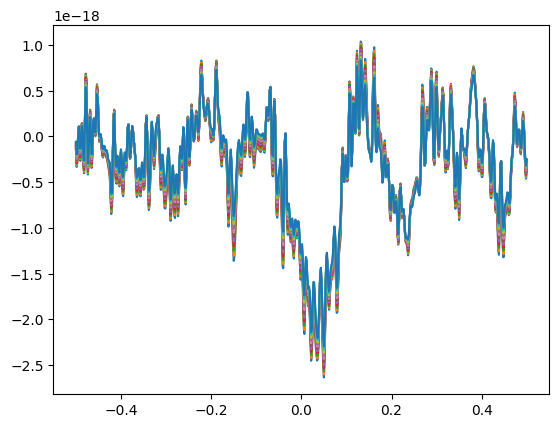

In [11]:
plt.plot(fif_times, src_layers[np.argmax(868)].T);

In [9]:
from kcsd import KCSD

ModuleNotFoundError: No module named 'kcsd'

In [43]:
# ele_pos = np.linspace(0,cortical_thickness[np.argmax(max_val)], num=11).reshape(-1,1)
ele_pos = np.linspace(0,1, num=11).reshape(-1,1)
pots = src_layers[np.argmax(max_val)]
csd = KCSD.KCSD1D(ele_pos, pots)

In [44]:
csd.values(estimate="CSD")

array([[ 1.75514009e-17,  1.77122537e-17,  1.14972849e-17, ...,
         4.34944711e-18, -1.47162660e-18, -7.37765389e-18],
       [ 1.67703534e-17,  1.69171991e-17,  1.09824975e-17, ...,
         4.16885022e-18, -1.38589578e-18, -7.02484971e-18],
       [ 1.55529377e-17,  1.56799124e-17,  1.01823635e-17, ...,
         3.88465404e-18, -1.25031883e-18, -6.47221202e-18],
       ...,
       [ 1.97406239e-17,  1.88097400e-17,  1.43414341e-17, ...,
         8.80964471e-18,  1.21961836e-17,  8.97485537e-18],
       [ 2.13492589e-17,  2.03467988e-17,  1.55213964e-17, ...,
         9.53742676e-18,  1.32413505e-17,  9.76960863e-18],
       [ 2.23902125e-17,  2.13428277e-17,  1.62861989e-17, ...,
         1.00083601e-17,  1.39200492e-17,  1.02865669e-17]])

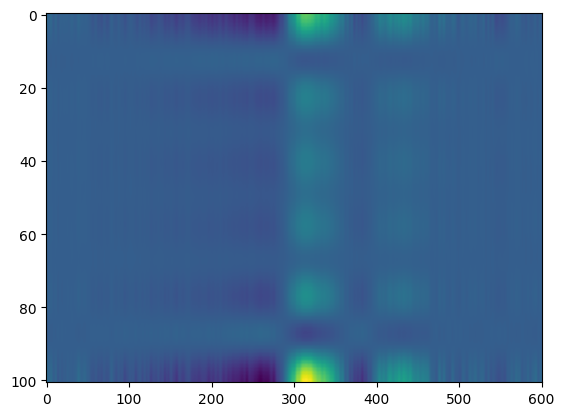

In [45]:
plt.imshow(csd.values(estimate="CSD"), aspect="auto")

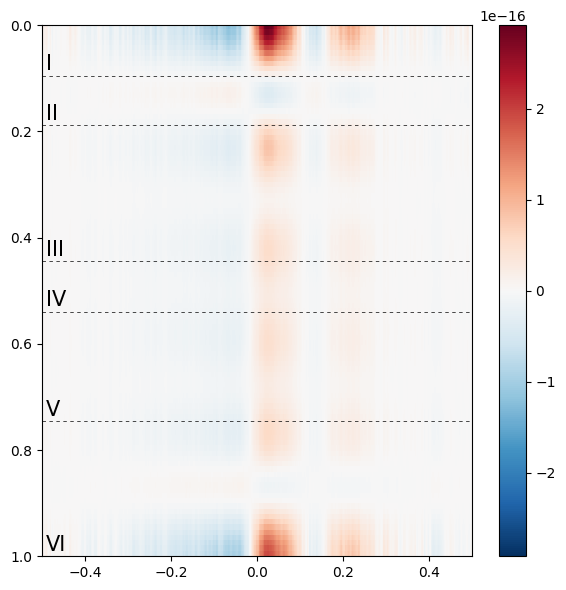

In [54]:
vertex = np.argmax(max_val)
f, ax = plt.subplots(1,1, figsize=(6, 6))
plot_csd(csd.values(estimate="CSD"), [vertex],info["big_brain_layers_path"], fif_times, ax=ax, cmap="RdBu_r")

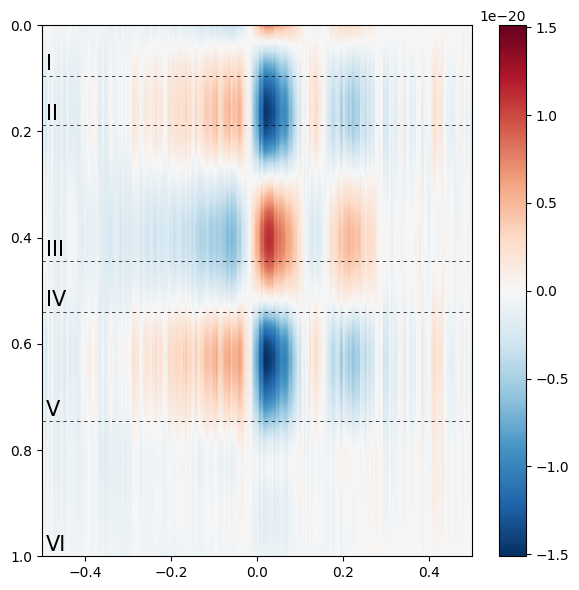

In [52]:
csd_g = np.gradient(np.gradient(pots, axis=0), axis=0, edge_order=2)
f, ax = plt.subplots(1,1, figsize=(6, 6))
plot_csd(aic_smooth_csd(csd_g), [vertex],info["big_brain_layers_path"], fif_times, ax=ax, cmap="RdBu_r")

In [51]:
def aicsmooth_csd(csd, layers=11):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = interp1d(x, csd[:, t], kind="quadratic")
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed

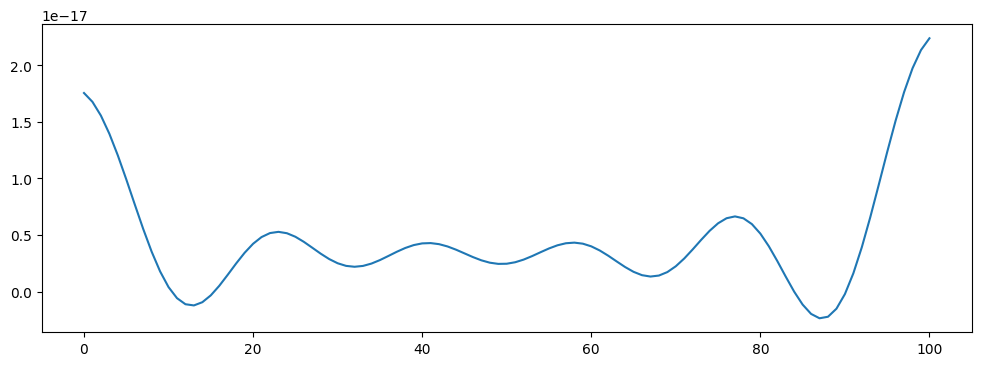

In [80]:
elec = np.linspace(0,1, num=11).reshape(-1,1)
pot = src_layers[np.argmax(max_val)][:, 0].reshape(-1,1)
kCS1D = KCSD.KCSD1D(elec, pot)
f, ax = plt.subplots(1,1, figsize=(12, 4))
ax.plot(kCS1D.values(estimate='CSD'));

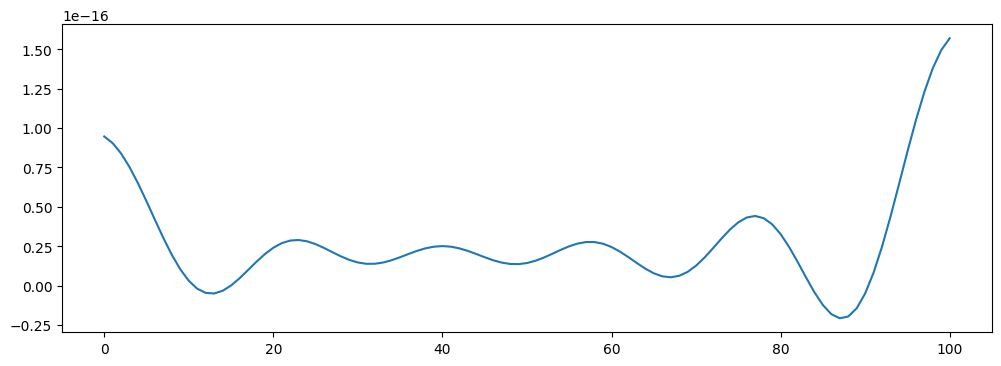

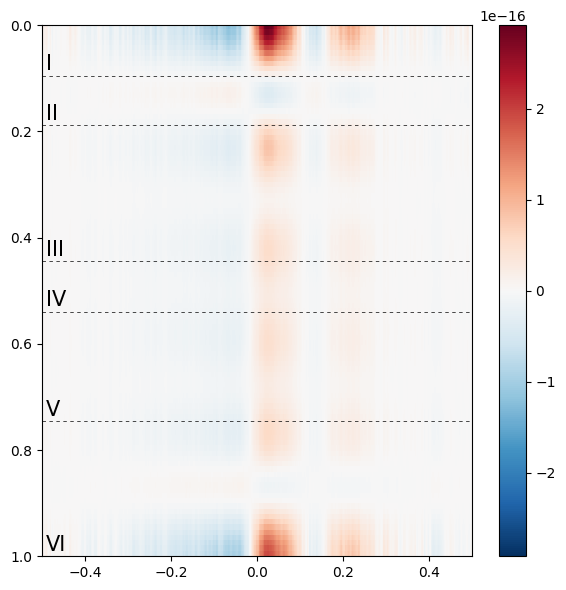

In [71]:
f, ax = plt.subplots(1,1, figsize=(6, 6))
plot_csd(kCS1D.values(estimate='CSD'), [vertex],info["big_brain_layers_path"], fif_times, ax=ax, cmap="RdBu_r")

In [16]:
def gen_gauss(mean, scale, amp, times):
    gaussian_tc = norm.pdf(times, mean, scale)
    gaussian_tc = (gaussian_tc / gaussian_tc.max())*amp
    return gaussian_tc


def cb_smooth_csd(csd, layers=11):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = interp1d(x, csd[:, t], kind="cubic")
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed

def pchip_smooth_csd(csd, layers=11):
    layers, time = csd.shape
    smoothed = []
    x = np.linspace(0, 1, num=layers)
    xs = np.linspace(0, 1, num=500)
    for t in range(time):
        fx = Akima1DInterpolator(x, csd[:, t])
        ys = fx(xs)
        smoothed.append(ys)
    smoothed = np.array(smoothed).T
    return smoothed

def plot_csd_simple(smooth_csd, times, ax, cb=True, cmap="RdBu_r", vmin_vmax=None, layers=11):
    smooth_csd = (smooth_csd - np.mean(smooth_csd)) / np.std(smooth_csd)
    max_smooth = np.max(np.abs(smooth_csd))
    if vmin_vmax == None:
        divnorm = colors.TwoSlopeNorm(vmin=-max_smooth, vcenter=0, vmax=max_smooth)
    else:
        divnorm = colors.TwoSlopeNorm(vmin=vmin_vmax[0], vcenter=0, vmax=vmin_vmax[1])
    extent = [times[0], times[-1], 1, 0]
    csd_imshow = ax.imshow(
        smooth_csd, norm=divnorm, origin="lower",
        aspect="auto", extent=extent,
        cmap=cmap, interpolation="none"
    )
    ax.set_ylim(1,0)
    ax.set_yticks(np.linspace(0,1, num=layers))
    ax.set_yticklabels(np.arange(1,12))
    for th in np.linspace(0,1, num=layers):
        ax.axhline(th, linestyle=(0, (5,5)), c="black", lw=0.5)
    if cb:
        plt.colorbar(csd_imshow, ax=ax)
    plt.tight_layout()

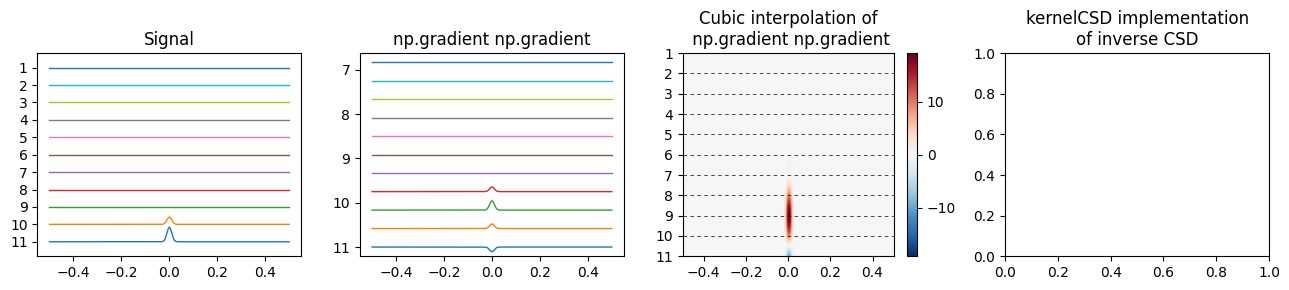

In [17]:
layers = 11

mmx = np.repeat(0.0, layers).reshape(-1,1)

loc = np.arange(3) + 8

mmx[loc[0]][0] = 0.0
mmx[loc[1]][0] = 0.1
mmx[loc[2]][0] = 0.2

amp = 0.001
spread = 0.01

gauss = gen_gauss(0, spread, amp, fif_times)
rec = np.repeat([gauss], layers, axis=0)
rec = rec * mmx[::-1]

max_amp = rec.max()

spacing = np.linspace(0, max_amp * 12, num=layers)
vis_rec = rec + spacing.reshape(-1,1)

f, ax = plt.subplots(1,4, figsize=(13, 3))
ax[0].plot(fif_times, vis_rec.T, lw=1)
ax[0].set_yticks(spacing)
ax[0].set_yticklabels(np.arange(1,12)[::-1])
ax[0].set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)

rec_grad = np.gradient(np.gradient(rec, axis=0), axis=0, edge_order=2)

max_grad = rec_grad.max()
spacing2 = np.linspace(0, max_grad*20, num=layers)
vis_rec_grad = rec_grad + spacing2.reshape(-1,1)
ax[1].plot(fif_times, vis_rec_grad.T, lw=1)
ax[1].set_yticks(spacing)
ax[1].set_yticklabels(np.arange(1,12)[::-1]);
ax[1].set_ylim(spacing2[0] - max_grad, spacing2[-1] + max_grad)

plot_csd_simple(cb_smooth_csd(rec_grad), fif_times, ax=ax[2])

# elec_spac = np.linspace(0,1, num=layers).reshape(-1,1)
# kCS1D = KCSD.KCSD1D(elec_spac, rec)
# plot_csd_simple(kCS1D.values(estimate="CSD"), fif_times, ax=ax[3])

ax[0].set_title("Signal")
ax[1].set_title("np.gradient np.gradient")
ax[2].set_title("Cubic interpolation of\n np.gradient np.gradient")
ax[3].set_title("kernelCSD implementation\nof inverse CSD")


plt.tight_layout()

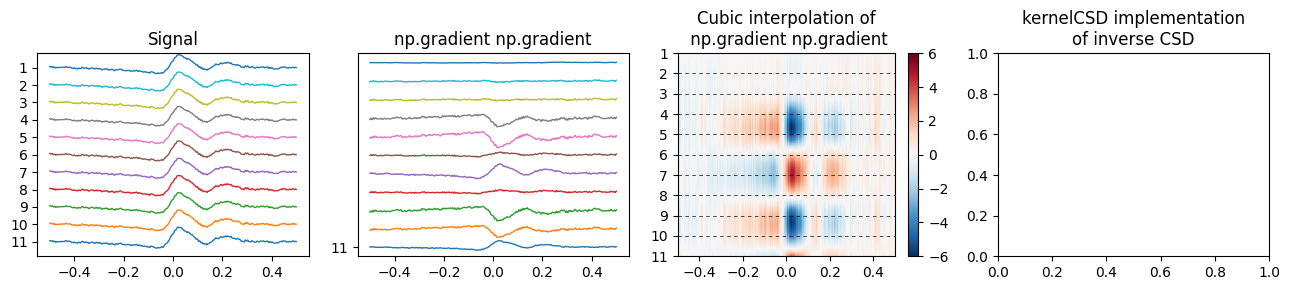

In [15]:
layers = 11

rec = src_layers[np.argmax(max_val)][::-1]

max_amp = rec.max()

spacing = np.linspace(0, max_amp * 12, num=layers)
vis_rec = rec + spacing.reshape(-1,1)

f, ax = plt.subplots(1,4, figsize=(13, 3))
ax[0].plot(fif_times, vis_rec.T, lw=1)
ax[0].set_yticks(spacing)
ax[0].set_yticklabels(np.arange(1,12)[::-1])
ax[0].set_ylim(spacing[0] - max_amp, spacing[-1] + max_amp)

rec_grad = np.gradient(np.gradient(rec, axis=0), axis=0, edge_order=2)

max_grad = rec_grad.max()
spacing2 = np.linspace(0, max_grad*20, num=layers)
vis_rec_grad = rec_grad + spacing2.reshape(-1,1)
ax[1].plot(fif_times, vis_rec_grad.T, lw=1)
ax[1].set_yticks(spacing)
ax[1].set_yticklabels(np.arange(1,12)[::-1]);
ax[1].set_ylim(spacing2[0] - max_grad, spacing2[-1] + max_grad)

plot_csd_simple(cb_smooth_csd(rec_grad), fif_times, ax=ax[2])

elec_spac = np.linspace(0,1, num=layers).reshape(-1,1)
# kCS1D = KCSD.KCSD1D(elec_spac, rec)
# plot_csd_simple(kCS1D.values(estimate="CSD"), fif_times, ax=ax[3])

ax[0].set_title("Signal")
ax[1].set_title("np.gradient np.gradient")
ax[2].set_title("Cubic interpolation of\n np.gradient np.gradient")
ax[3].set_title("kernelCSD implementation\nof inverse CSD")

plt.tight_layout()